In [1]:
from src.models.vae import VAE
from src.trainer import ClearTCVAETrainer
from src.utils.display_utils import interpolate_latent
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
np.random.seed(101)
torch.manual_seed(101)

In [8]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [9]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3763.22item/s]


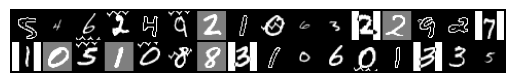

In [10]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


### cosine sim + mi minimization (tc)

In [11]:
Z_DIM = 16
TEMP = 0.1
ALPHA = 1e2

vae = VAE(total_z_dim=Z_DIM).to(device)
factor_cls = nn.Sequential(
    nn.Linear(Z_DIM, Z_DIM),
    nn.ReLU(),
    nn.Linear(Z_DIM, 1),
    nn.Sigmoid(),
).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
factor_optimizer = torch.optim.Adam(factor_cls.parameters(), lr=1e-4)
trainer = ClearTCVAETrainer(
    vae,
    factor_cls,
    optimizers={"vae_optim": vae_optimizer, "factor_optim": factor_optimizer},
    sim_fn="cosine",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 8,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "lambda": 1,
    },
    verbose_period=5,
    device=device,
)

In [12]:
factor_d_losses = trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 101.38it/s]


val_recontr_loss=60.661, val_kl_c=9.698, val_kl_s=15.433, val_c_loss=0.252, val_mi_loss=0.149
gMIG: 0.177; mse: 60.661


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 291.77it/s]


val_recontr_loss=31.204, val_kl_c=10.982, val_kl_s=16.954, val_c_loss=0.116, val_mi_loss=0.043
gMIG: 0.223; mse: 31.204


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 282.62it/s]


val_recontr_loss=24.569, val_kl_c=11.743, val_kl_s=17.070, val_c_loss=0.097, val_mi_loss=0.091
gMIG: 0.24; mse: 24.569


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 262.71it/s]


val_recontr_loss=21.676, val_kl_c=12.787, val_kl_s=17.405, val_c_loss=0.098, val_mi_loss=0.151
gMIG: 0.251; mse: 21.676


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 282.45it/s]


val_recontr_loss=19.994, val_kl_c=13.233, val_kl_s=17.584, val_c_loss=0.087, val_mi_loss=0.165
gMIG: 0.263; mse: 19.994


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 291.85it/s]


val_recontr_loss=18.771, val_kl_c=13.865, val_kl_s=17.761, val_c_loss=0.090, val_mi_loss=0.182
gMIG: 0.27; mse: 18.771


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 279.48it/s]


val_recontr_loss=18.859, val_kl_c=14.556, val_kl_s=18.332, val_c_loss=0.107, val_mi_loss=0.195
gMIG: 0.27; mse: 18.859


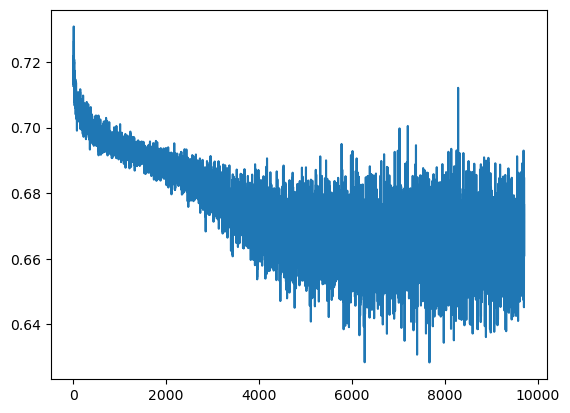

In [13]:
plt.plot(factor_d_losses)

In [14]:
trainer.evaluate(test_loader, False, 0)

(0.26956852910121687, 18.622047424316406)

In [15]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 436.04it/s]


In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

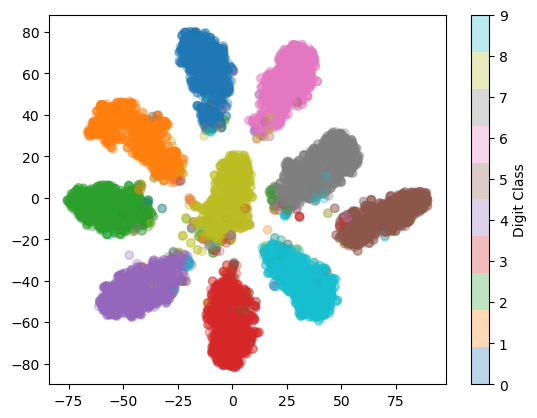

In [17]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

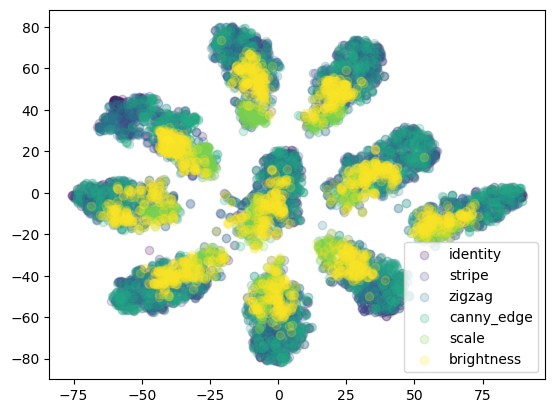

In [18]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [19]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

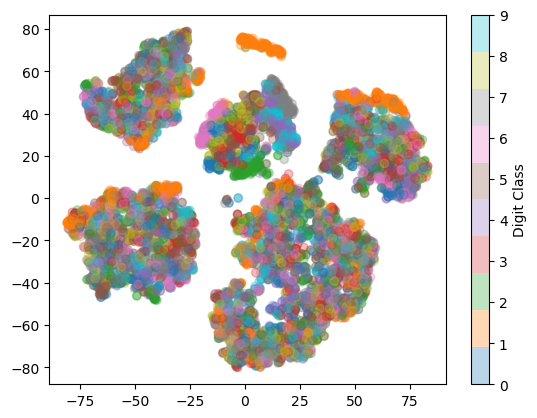

In [20]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

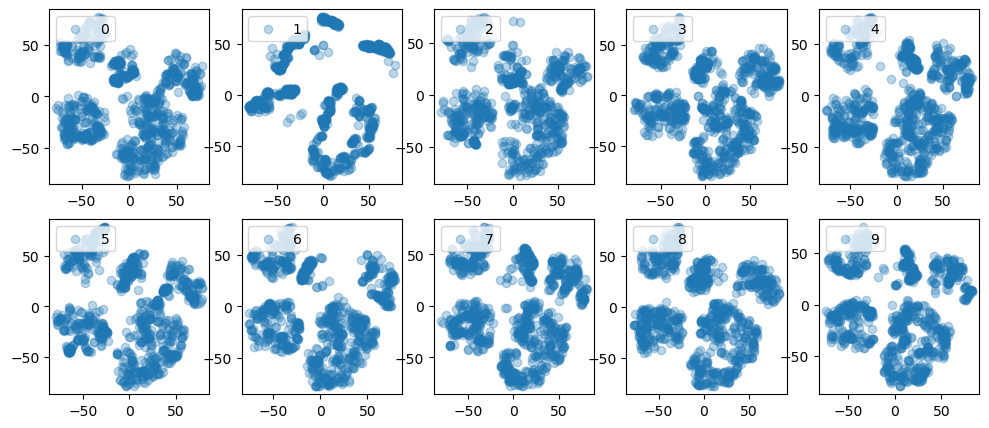

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

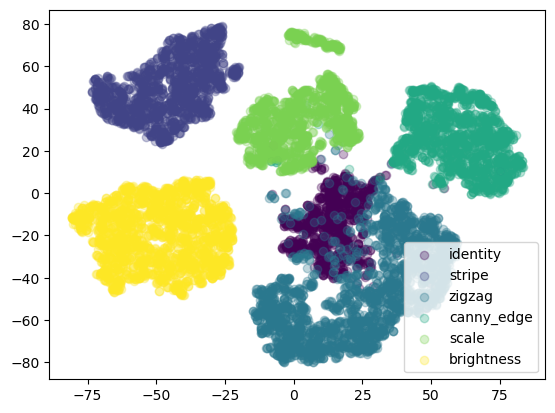

In [22]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()